<a href="https://colab.research.google.com/github/anonymousSPji/Skin-Cancer-Prediction-System/blob/main/trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()  # Choose the 'kaggle.json' file downloaded from Kaggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dummyiam","key":"a51416c4048e218e0fc5791658d6a45f"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:21<00:00, 289MB/s]
100% 5.20G/5.20G [00:21<00:00, 261MB/s]


In [5]:
import zipfile

# Unzip the dataset to a folder
with zipfile.ZipFile("skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Load dataset
train_df = pd.read_csv('/content/dataset/HAM10000_metadata.csv')


# Display first few rows of the dataframe
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


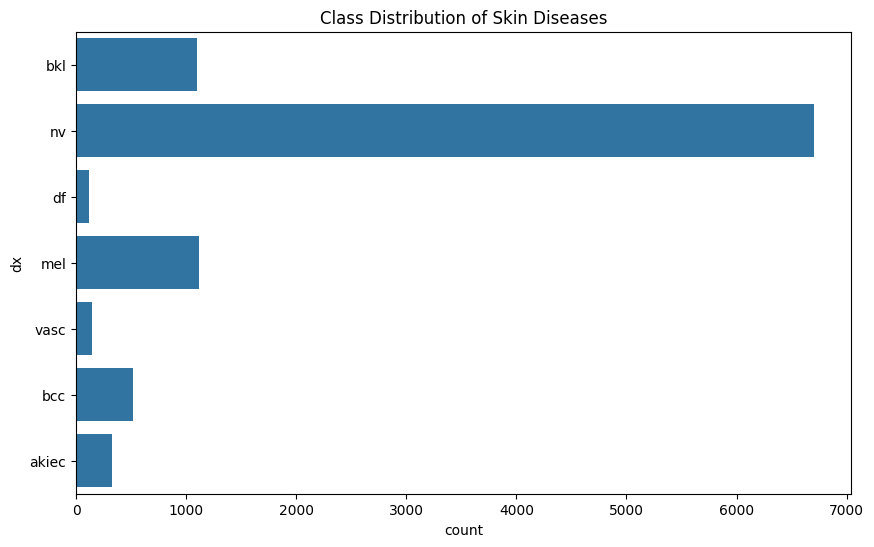

In [7]:
# Check class distribution
class_distribution = train_df['dx'].value_counts()
print(class_distribution)

# Plot the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(y=train_df['dx'])
plt.title('Class Distribution of Skin Diseases')
plt.show()

In [8]:
import os
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

# Define directories for both parts
image_dir_part_1 = '/content/dataset/HAM10000_images_part_1'
image_dir_part_2 = '/content/dataset/HAM10000_images_part_2'


# Function to load image by checking both parts
def load_image_by_id(img_id):
    img_path_part_1 = os.path.join(image_dir_part_1, f'{img_id}.jpg')
    img_path_part_2 = os.path.join(image_dir_part_2, f'{img_id}.jpg')

    # Check if the image exists in part 1 or part 2
    if os.path.exists(img_path_part_1):
        return load_img(img_path_part_1)
    elif os.path.exists(img_path_part_2):
        return load_img(img_path_part_2)
    else:
        print(f"Image {img_id} not found in part 1 or part 2.")
        return None

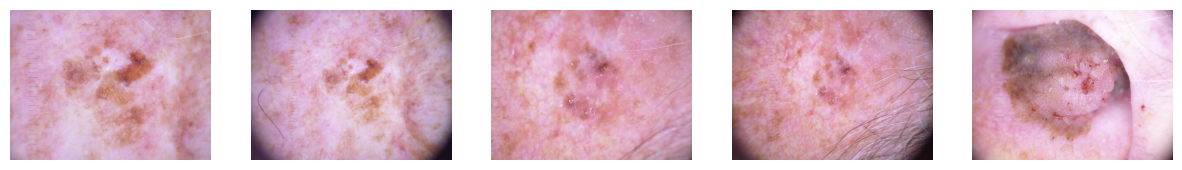

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [9]:
# Visualize a few sample images
sample_image_paths = train_df['image_id'].iloc[:5]
sample_images = [load_image_by_id(img_id) for img_id in sample_image_paths if load_image_by_id(img_id) is not None]

# Plot the images
plt.figure(figsize=(15, 5))
for i, image in enumerate(sample_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

train_df['age'].fillna(train_df['age'].mean(), inplace=True)
print(train_df.isnull().sum())

from sklearn.preprocessing import LabelEncoder

# Encode labels (class names to numeric)
label_encoder = LabelEncoder()
train_df['encoded_labels'] = label_encoder.fit_transform(train_df['dx'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(train_df, test_size=0.2, stratify=train_df['encoded_labels'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['encoded_labels'], random_state=42)

# The rest of your data pipeline follows

# Directories for both parts
image_dir_part_1 = '/content/dataset/HAM10000_images_part_1'
image_dir_part_2 = '/content/dataset/HAM10000_images_part_2'

# Data augmentation setup
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing the images
    rotation_range=30,  # Rotation for augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom function to load images from either directory part
def load_image_path(img_id):
    img_path_part_1 = os.path.join(image_dir_part_1, f'{img_id}.jpg')
    img_path_part_2 = os.path.join(image_dir_part_2, f'{img_id}.jpg')

    if os.path.exists(img_path_part_1):
        return img_path_part_1
    elif os.path.exists(img_path_part_2):
        return img_path_part_2
    else:
        return None

# Update the 'image_id' column with the full image path
train_df['image_path'] = train_df['image_id'].apply(load_image_path)
valid_df['image_path'] = valid_df['image_id'].apply(load_image_path)
test_df['image_path'] = test_df['image_id'].apply(load_image_path)

# Train and Validation Generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,  # directory=None because paths are already full in 'image_path'
    x_col='image_path',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,  # directory=None because paths are already full in 'image_path'
    x_col='image_path',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)
# Test Generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # Assuming 'image_path' is already in your DataFrame
    x_col='image_path',
    y_col='encoded_labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)
# Check how many images are found
print(f'Train generator found {train_generator.samples} images')
print(f'Validation generator found {valid_generator.samples} images')
print(f'Test generator found {test_generator.samples} images')

Found 6409 validated image filenames.
Found 801 validated image filenames.
Found 802 validated image filenames.
Train generator found 6409 images
Validation generator found 801 images
Test generator found 802 images


In [13]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import tensorflow as tf


In [14]:
# Function to build ResNet50
def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Function to build InceptionV3
def build_inception_model(input_shape, num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Function to build VGG16
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [15]:
# Get number of classes
num_classes = train_df['encoded_labels'].nunique()

# Build and compile models
resnet_model = build_resnet_model((224, 224, 3), num_classes)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

inception_model = build_inception_model((224, 224, 3), num_classes)
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

vgg16_model = build_vgg16_model((224, 224, 3), num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Train models for 50 epochs without early stopping or callbacks
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50
)

history_inception = inception_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50
)

history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50)

Epoch 1/50
201/201 [==============================] - 167s 815ms/step - loss: 1.1651 - accuracy: 0.6661 - val_loss: 1.1371 - val_accuracy: 0.6692
Epoch 2/50
201/201 [==============================] - 163s 812ms/step - loss: 1.1393 - accuracy: 0.6692 - val_loss: 1.1175 - val_accuracy: 0.6692
Epoch 3/50
201/201 [==============================] - 161s 798ms/step - loss: 1.1325 - accuracy: 0.6697 - val_loss: 1.1269 - val_accuracy: 0.6692
Epoch 4/50
201/201 [==============================] - 159s 789ms/step - loss: 1.1190 - accuracy: 0.6692 - val_loss: 1.1495 - val_accuracy: 0.6692
Epoch 5/50
201/201 [==============================] - 160s 796ms/step - loss: 1.1129 - accuracy: 0.6694 - val_loss: 1.0909 - val_accuracy: 0.6692
Epoch 6/50
201/201 [==============================] - 158s 786ms/step - loss: 1.1041 - accuracy: 0.6697 - val_loss: 1.1042 - val_accuracy: 0.6692
Epoch 7/50
201/201 [==============================] - 160s 796ms/step - loss: 1.0977 - accuracy: 0.6697 - val_loss: 1.1042 -

In [ ]:
# Plot training/validation loss comparison
plt.plot(history_resnet.history['val_loss'], label='ResNet50')
plt.plot(history_inception.history['val_loss'], label='InceptionV3')
plt.plot(history_vgg16.history['val_loss'], label='Vgg16')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.show()

# Display final results
results = {
    'Model': ['ResNet50', 'InceptionV3', 'Vgg16'],
    'Validation Accuracy': [
        max(history_resnet.history['val_accuracy']),
        max(history_inception.history['val_accuracy']),
        max(history_vgg16.history['val_accuracy'])
    ],
    'Validation Loss': [
        min(history_resnet.history['val_loss']),
        min(history_inception.history['val_loss']),
        min(history_vgg16.history['val_loss'])
    ]
}
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
# Plot loss and accuracy for each model
plt.figure(figsize=(12, 6))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='ResNet50')
plt.plot(history_inception.history['loss'], label='InceptionV3')
plt.plot(history_vgg16.history['loss'], label='Vgg16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

# Training accuracy
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='ResNet50')
plt.plot(history_inception.history['accuracy'], label='InceptionV3')
plt.plot(history_vgg16.history['accuracy'], label='Vgg16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate each model on the test set
resnet_test_results = resnet_model.evaluate(test_generator)
inception_test_results = inception_model.evaluate(test_generator)
vgg16_model_test_results = vgg16_model.evaluate(test_generator)


print(f"ResNet50 Test Accuracy: {resnet_test_results[1]:.4f}")
print(f"InceptionV3 Test Accuracy: {inception_test_results[1]:.4f}")
print(f"Vgg16_model Test Accuracy: {vgg16_model_test_results[1]:.4f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define helper function to generate classification report and confusion matrix
def evaluate_model(model, test_generator, label_encoder):
    # Get predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)  # Predicted class indices

    # True classes are already integers (not one-hot encoded)
    true_classes = test_generator.labels  # No need to apply np.argmax here

    # Generate classification report
    print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate each model with detailed classification reports
print("ResNet50 Model Evaluation:")
evaluate_model(resnet_model, test_generator, label_encoder)

print("InceptionV3 Model Evaluation:")
evaluate_model(inception_model, test_generator, label_encoder)

print("Vgg16 Model Evaluation:")
evaluate_model(vgg16_model, test_generator, label_encoder)